
## Project description
In this project, I propose to analyse the carboon footprint of recipes based on pictures. In the long term, users would be able to 1) get an approximation of their carboon footprint from uploading a picture and 2) get low carbon recipe suggestions based on user preferences. Food consumption corresponds to an estimated 15-30% of greenhouse gas emissions. The project builds upon the 1M+ recipe dataset and existing estimates of CO2 emissions of ingredients.
It would allow the education of individuals on their individual footprints, and could help inform larger businesses (e.g. restaurants, food suppliers etc.).


### Recipe dataset
- [github repo](https://github.com/torralba-lab/im2recipe#recipe1m-dataset)
- [paper](http://pic2recipe.csail.mit.edu/)

### Tmrow database

- [github file](https://raw.githubusercontent.com/tmrowco/tmrowapp-contrib/90c0c3f64b6b38dc4201f42cd67300a4ed01524e/co2eq/purchase/footprints.yml)
- [repo](https://github.com/tmrowco/tmrowapp-contrib) 

In [1]:
import json
import pandas as pd
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import json
with open('../recipe1M_layers/layer1.json', 'r') as f:
    array = json.load(f)

In [3]:
import json
with open('../recipe1M_layers/det_ingrs.json', 'r') as f:
    det_ingrs = json.load(f)

let's count the number of entries

In [17]:
len(det_ingrs)

1029720

let's count the number of unique ingredients

In [21]:
ingr_500 = [[f['text'] for i,f in enumerate(rec['ingredients']) if rec['valid'][i]] for rec in det_ingrs]

In [23]:
def flatten(l):
    out = []
    for item in l:
        if isinstance(item, (list, tuple)):
            out.extend(flatten(item))
        else:
            out.append(item)
    return out

In [24]:
flat_ing = flatten(ingr_500)

In [27]:
from collections import Counter

In [33]:
count_ingr = Counter(flat_ing)
len (count_ingr.keys())

18253

let's first plot the frequency of ingredients in the recipe database

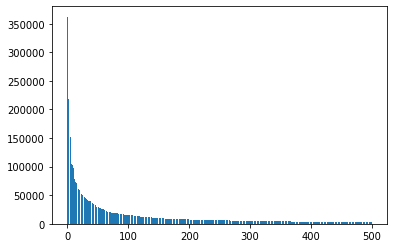

In [770]:
plt.bar(np.arange(500), [i[1] for i in count_ingr.most_common(500)]);

let's now load the tmrow database to calculate approx. CO2 emissions per ingredient

In [38]:
import yaml

In [219]:
with open("../recipe1M_layers/footprints.yml", 'r') as stream:
    try:
        file = (yaml.safe_load(stream))
    except yaml.YAMLError as exc:
        print(exc)

In [220]:
food_cats = file['_children']['Food']['_children'].keys()
food_tmrow = flatten([list(file['_children']['Food']['_children'][cat]['_children'].keys()) for cat in food_cats])

In [ ]:
let's inspect the categories of food in 

In [221]:
food_cats

dict_keys(['Beverages', 'Dairy', 'Fruits', 'Grains', 'Meat', 'Nuts', 'Sweets', 'Seafood', 'Vegetables'])

Let's cross reference the two data-sets. We use jaro winkler to measure string similarity. It's not perfect, but it'll do for now. Let's clean the strings in both data sets too.

I remove some descriptive words that don't specify the ingredient type/source.

In [224]:
from Levenshtein import jaro_winkler
import string
from nltk.tokenize import word_tokenize

In [564]:
dirty_words = ['fresh','sea', 'paste','unsalted','sauce','red','light','brown','boneless','skinless','breasts','ground',
 'powder', 'dried', 'whole', 'boiling', 'whipping', 'shredded', 'crushed', 'flakes', 'whole', 'low',
 'fat', 'semi', 'sweet' , 'flat', 'leaf' , 'hot', 'italian', 'unsweetened', 'plain', 'swiss', 
  'sodium', 'seasoning', 'rolled', 'nonfat', 'peel', 'chopped', 'of', 'soup', 'boiled', 'roasted', 'sun',
 'roma', 'prepared', 'all', 'purpose', 'purpose', 'extract', 'heavy', 'superfine',
               'baby', 'freshly', 'extra', 'virgin', 'white', 'great',
               'frozen', 'northern', 'marinated', 'pickled', 'self', 'rising', 'coarse', 'flaked', 'dry', 
              'nonstick', 'maraschino', 'large', 'baking', 'old', 'fashioned',
              'quick', 'cooking', 'pancetta', 'salted', 'fine', 'sweetened','unflavored']

def clean_str(input_str): 
    lower_str = input_str.lower()
    
    text_str = list(filter(lambda token: token not in string.punctuation, lower_str))
    text_str = "".join(text_str)
    text_str = ' '.join(text_str.split())

    tokens = word_tokenize(text_str)
    
    if 'cheese' in tokens:
        out = 'cheese'
        
    else:
        tokens = [word for word in tokens if word not in dirty_words]
        out = " ".join(tokens)
        out = out.replace("bacon", "pork")
        out = out.replace("prosciutto", "pork")

    return out

let's clean both lists of ingredients

In [736]:
clean_tmrow = np.array([clean_str(i) for i in food_tmrow])
clean_rec = np.array([clean_str(i[0]) for i in count_ingr.most_common(1000)])

let's keep get the original string and the frequency of the item in the recipe dataset.

In [652]:
rec_freqs = [i[1] for i in count_ingr.most_common(1000)]
raw_rec = [np.array([i[0] for i in count_ingr.most_common(1000)])]

calculate jaro winkler score for all items between tmrow and recipe items

In [567]:
list_of_jar = [[jaro_winkler(rec_ingr, li) for li in clean_tmrow] for rec_ingr in clean_rec]

for each top 1000 ingredient, get top3 (with scores)

In [763]:
dict_top1000 = {}
for i in range(len(clean_rec)):
    dict_top1000[str(i)]={
        'word':clean_rec[i],
        'similar':[[w,p] for w,p in zip(clean_tmrow[np.array(list_of_jar[i]).argsort()[-3:][::-1]], 
                       np.array(list_of_jar[i])[np.array(list_of_jar[i]).argsort()[-3:][::-1]])
                       ],
        'freq': rec_freqs[i],
        'raw':raw_rec[0][i]
    }

number of found items from top1000

In [764]:
matches = [[dict_top1000[str(i)]] for i in range(len(list_of_jar)) if dict_top1000[str(i)]['similar'][0][1]>0.88]

In [765]:
co2_out = []
for food_cat in food_cats:
    items = file['_children']['Food']['_children'][food_cat]['_children']
    for food_item in list(items.keys()):
        co2_out.append(items[food_item]['intensityKilograms'])
        
dict_co2out = {}
for i,item in enumerate(clean_tmrow):
    dict_co2out[item]=co2_out[i]   

## Questions:

### A) Can we map the frequency of ingredient vs how much it emits?


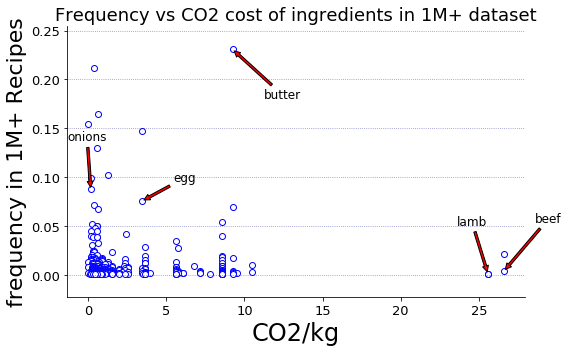

In [1016]:
fig = plt.figure(figsize=(8, 5))#
ax1 = fig.add_subplot(111)

ax1.set_title('Frequency vs CO2 cost of ingredients in 1M+ dataset', size=18)


ax1.scatter([dict_co2out[m[0]['similar'][0][0]] for m in matches], (np.array([m[0]['freq']  for m in matches])/len(det_ingrs)),
            facecolor='white', edgecolor='b')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.grid(axis='y',color='darkblue', alpha=0.5, linestyle=':')

ax1.set_ylabel('frequency in 1M+ Recipes', size=22)
ax1.set_xlabel('CO2/kg', size=24)

x_beef = np.array([dict_co2out[m[0]['similar'][0][0]] for m in matches])[183]
y_beef = (np.array([m[0]['freq']  for m in matches])/len(det_ingrs))[183]
ax1.annotate('beef', xy=(x_beef, y_beef), xytext=(x_beef+2, y_beef+.05),size=12,
            arrowprops=dict(facecolor='red',arrowstyle='simple'))

x_lamb = np.array([dict_co2out[m[0]['similar'][0][0]] for m in matches])[408]
y_lamb = (np.array([m[0]['freq']  for m in matches])/len(det_ingrs))[408]
ax1.annotate('lamb', xy=(x_lamb, y_lamb), xytext=(x_lamb-2, y_lamb+.05),size=12,
            arrowprops=dict(facecolor='red',arrowstyle='simple'))

x_lamb = np.array([dict_co2out[m[0]['similar'][0][0]] for m in matches])[0]
y_lamb = (np.array([m[0]['freq']  for m in matches])/len(det_ingrs))[0]
ax1.annotate('butter', xy=(x_lamb, y_lamb), xytext=(x_lamb+2, y_lamb-.05),size=12,
            arrowprops=dict(facecolor='red',arrowstyle='simple'))

x_lamb = np.array([dict_co2out[m[0]['similar'][0][0]] for m in matches])[9]
y_lamb = (np.array([m[0]['freq']  for m in matches])/len(det_ingrs))[9]
ax1.annotate('egg', xy=(x_lamb, y_lamb), xytext=(x_lamb+2, y_lamb+.02),size=12,
            arrowprops=dict(facecolor='red',arrowstyle='simple'))

x_lamb = np.array([dict_co2out[m[0]['similar'][0][0]] for m in matches])[8]
y_lamb = (np.array([m[0]['freq']  for m in matches])/len(det_ingrs))[8]
ax1.annotate('onions', xy=(x_lamb, y_lamb), xytext=(x_lamb-1.5, y_lamb+.05),size=12,
            arrowprops=dict(facecolor='red',arrowstyle='simple'))

ax1.tick_params(axis='both', which='major', labelsize=13)

plt.tight_layout()

### B) Can we get an estimate of the "CO2 emission" distribution of recipes in the dataset   
- Note that these are very rough/poor estimations since we're not taking into account proportions, and is tbus more of a proof of concept.

In [935]:
raw_dict = {}
for i in range(len(matches)):
    raw_dict[matches[i][0]['raw']]= np.array([dict_co2out[m[0]['similar'][0][0]] for m in matches])[i]

In [991]:
def get_co2(recipe_id):
    for rec in det_ingrs :
        sum_co2 = 0
        if rec['id']==recipe_id:
            # ingrs_count = 0
            ingrs = [f['text'] for i,f in enumerate(rec['ingredients']) if rec['valid'][i]]
            ing_exist = [i for i in ingrs if i in list(raw_dict.keys())]
            for ing in ing_exist:
                sum_co2 += raw_dict[ing]
                    # print(raw_dict[ing], ing)
                    # ingrs_count+=1
            break   
    return sum_co2

In [992]:
ar_samples = np.random.choice(len(array),1000)
ar_samples = np.array(array)[ar_samples]

In [996]:
rec_co2 = [[rec['title'], get_co2(rec['id'])] for rec in tqdm(ar_samples)]

'ok'

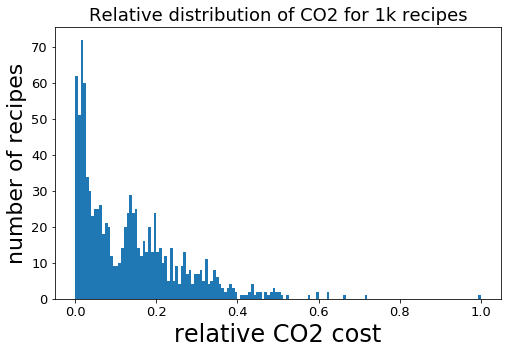

In [1015]:
fig = plt.figure(figsize=(8, 5))#
ax1 = fig.add_subplot(111)
ax1.set_title('Relative distribution of CO2 for 1k recipes', size=18)
ax1.hist([i[1] for i in rec_co2]/(max([i[1] for i in rec_co2])), bins=150);
ax1.tick_params(axis='both', which='major', labelsize=13)

ax1.set_ylabel('number of recipes', size=22);
ax1.set_xlabel('relative CO2 cost', size=24);

## Future work:
    - better matching/coverage of ingredients to emissions
    - take into account portions

    - work with embeddings introduced in 1M+ paper to better visualise the dataset
    - image to CO2 pipeline